In [1]:
import numpy as np
import math
import copy
import matplotlib.pylab as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
import SetPub
SetPub.set_pub()
np.random.seed(12211)

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_funcs

from help_train import decay as decay

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0']


In [3]:
num_train = 200000
num_test = 20000
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew', 'OBSuq'][7]
surveystring = ['SDSS', 'VIPERS', 'DEEP2', 'PRIMUS'] # One file for each survey, minus primus -- not cool enough :P

n_epochs = 2000 #20
D = 5
K = 3
learning_rate = 1e-5
decay_rate= 1e-3
batch_size = 1024
save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [4]:
save_mod

'saved_hubs/tf2models/Train_UMnew_lr_1e-05_dr0.001_ne2000_k3_nt200000'

In [5]:
def load_trained_models(save_mod):
    ## load rescaling routines for colors/magnitude
    preproc = Pipeline([('stdscaler', StandardScaler())])
    scalerfile = save_mod + '_scaling_X'
    preproc = pickle.load(open(scalerfile, 'rb'))
    
    ## load rescaling routine for redshift
    preproc_y = Pipeline([('stdscaler', MinMaxScaler())])
    scalerfile = save_mod + '_scaling_y'
    preproc_y = pickle.load(open(scalerfile, 'rb'))

    ## Mixed density network
    non_lin_act = tf.nn.relu #tf.nn.tanh
    y_true = tf.keras.Input(shape=(1,))
    inputs = tf.keras.Input(shape=(D,))
    layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
    layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
    layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
    layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
    layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
    layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
    layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
    layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
    layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
    mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
    var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
    pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)
    model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')
    
    # load network weights
    model_train.load_weights(save_mod + '.h5')
    
    return preproc, preproc_y, model_train

In [6]:
def minmax_cutsOBSarr(X, Xerr, y, l):
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    # print( np.array(mask_cond).shape)
    X_new = X[mask_cond]
    X_err_new = Xerr[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    # print(X_new.shape)
    return X_new, X_err_new, y_new, l_new, mask_cond

In [7]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [8]:
def loadTest(dirIn = '../../Data/fromGalaxev/photozs/datasets/data_feb_2021/'):
    
    test_data = np.load(dirIn + 'test_' + Testset + '.npy') 

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    print_limits(X_test, y_test)

    X_err = np.load(dirIn + 'test_' + Testset +'_err.npy') 
    test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return X_test, y_test, X_err, test_labels

In [9]:
## Loading color, redshift information from different surveys
X_test, y_test, X_err, label_test = loadTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_feb_2021/')

----------
number of datapoints:  4339
z-minmax:  7.926745e-06 7.01
ColMag-min:  [ -5.188  -3.89   -2.103 -15.923  12.115]
ColMag-max:  [17.029  7.926  4.182  2.265 25.71 ]
----------


In [10]:
# Remove bad values
print(X_test.shape)
X_test, X_err, y_test, label_test = help_funcs.rm_bad_vals(X_test, X_err, y_test, label_test)
print(X_test.shape)

(4339, 5)
(3994, 5)


In [11]:
## Removing galaxies outside the range of prediction scheme. 
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.001 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 

X_test, X_err, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, X_err, y_test, label_test)
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in test data: (2551, 5)
Size of output in test data: (2551,)


In [12]:
## Loading trained models and rescaling routines
preproc, preproc_y, model_train = load_trained_models(save_mod)

/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/acossairt/miniconda3/envs/ML_env/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Perturb inputs

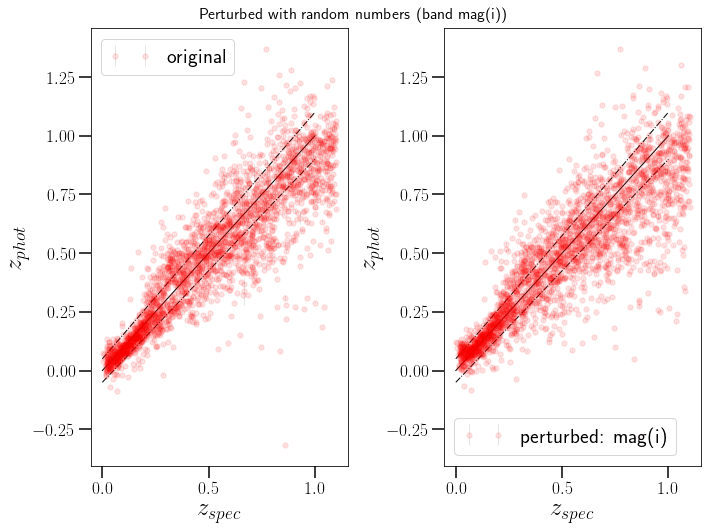

In [13]:
# New version
# Perturb one band (or multiple)
band_n = 4
delta_c = 1.2
approach = 'b'
prtb_X_test = help_funcs.perturb(X_test, band_n, delta_c = delta_c, approach = approach, X_err = X_err)
band_names = ["u-g", "g-r", "r-i", "i-z", "mag(i)"]

# New perturbed and unperturbed
prtb_y_pred_mean, prtb_y_pred_std  = help_funcs.prediction_zp_all(prtb_X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)
og_y_pred_mean, og_y_pred_std  = help_funcs.prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)

# Plot those comparisons
if approach != 'd':
    labels = ["original", "perturbed: " + band_names[band_n]]
else:
    labels = ["original", "perturbed"]
fig, axs = help_funcs.squish_plot_side_by_sides(y_test, [og_y_pred_mean, prtb_y_pred_mean], [og_y_pred_std, prtb_y_pred_std], labels, approach, band_n, delta_c)

# Title and save
save = True
if save:
    if approach != 'd':
        suffix = "_deltac_" + str(delta_c) if approach == 'a' else ""
        fig.savefig(approach + "_band_" + str(band_n) + suffix + ".png")
    else:
        fig.savefig("d_all_bands_survey.png")
fig.show()

## Perturbations and Validations

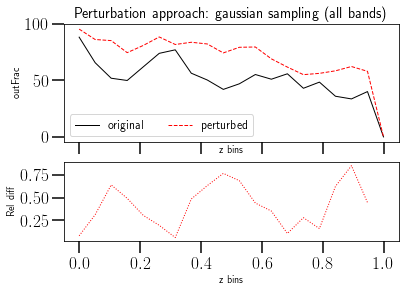

In [14]:
# Perturb lots of bands (approach b, c, or d)
save = True
approach = 'd'
metric_name = 'outFrac'
ncol = 3 # Should this actually be vertical and outside the plots, perhaps?
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})
band_names = ["u-g", "g-r", "r-i", "i-z", "mag(i)"]

# Perturb
prtb_X_test_lst, prtb_y_pred_mean_lst, prtb_y_pred_std, og_y_pred_mean, og_y_pred_std = help_funcs.squish_perturb_mult(X_test, X_err, label_test, save_mod, surveystring, model_train, preproc, preproc_y, approach)
    
# Validate and plot og data first
og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.squish_validate(y_test, og_y_pred_mean)
if metric_name == "sigma":
    og_metric = og_sigmaNMAD_array
    metric_label = r'$\sigma_{NMAD}$'
elif metric_name == "outFrac":
    og_metric = og_outFr_array
    metric_label = "outFrac"
fig, ax1 = help_funcs.plot_metric(og_metric, metric_label, approach, fig = fig, ax = ax1, label = "original", color = "black", linestyle = '-')
ax1.legend(ncol = ncol)

# Plot the validations of the perturbed data
if approach != 'd':
   
    print(len(prtb_y_pred_mean_lst))
    for i, y_pred_mean in enumerate(prtb_y_pred_mean_lst):
        this_label = band_names[i]
        sigmaNMAD_array, outFr_array, bins = help_funcs.squish_validate(y_test, y_pred_mean)
        if metric_name == "sigma":
            metric = sigmaNMAD_array
            metric_label = r'$\sigma_{NMAD}$'
            lims = [-0.05,0.05]
        elif metric_name == "outFrac":
            metric = outFr_array
            metric_label = "outFrac"
            lims = [-0.5, 1.5]
        fig, ax1 = help_funcs.plot_metric(metric, metric_label, approach, fig = fig, ax = ax1, label = this_label, linestyle = '--')
        ax1.legend(ncol = ncol)

        # Look at relative difference
        relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
        ax2.plot(bins[:-1], relative_diff, linestyle = ":")
        ax2.set_ylabel("Rel diff")
        ax2.set_xlabel("z bins")
        if metric_name == "sigma":
            ax2.set_ylim((lims[0],lims[1]))
        
else: # How can I reduce the repetition here?

    sigmaNMAD_array, outFr_array, bins = help_funcs.squish_validate(y_test, prtb_y_pred_mean_lst[0])
    if metric_name == "sigma":
        metric = sigmaNMAD_array
        metric_label = r'$\sigma_{NMAD}$'
    elif metric_name == "outFrac":
        metric = outFr_array
        metric_label = "outFrac"
    fig, ax1 = help_funcs.plot_metric(metric, metric_label, approach, fig = fig, ax = ax1, label = "perturbed", linestyle = '--')
    ax1.legend(ncol = ncol)

    # Look at relative difference
    relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
    ax2.plot(bins[:-1], relative_diff, linestyle = ":")
    ax2.set_ylabel("Rel diff")
    ax2.set_xlabel("z bins")

if save:
    fig.savefig(metric_name + "_approach_" + approach + "_rel_corr" + ".png")

### Special version for approach 'a'

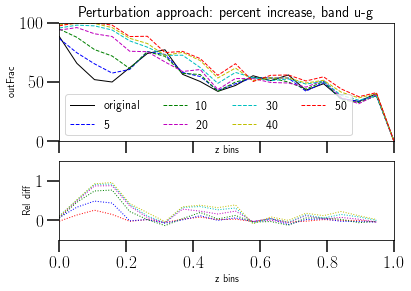

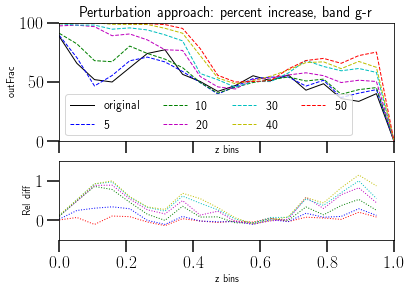

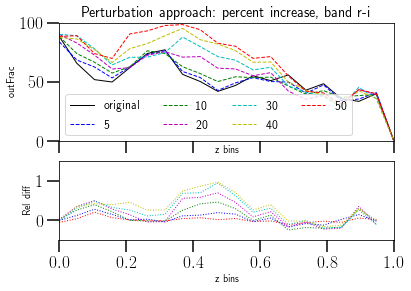

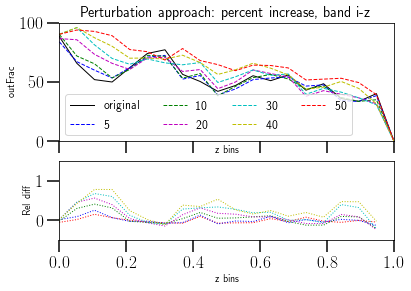

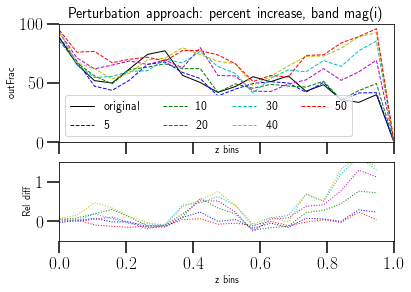

In [15]:
# For approach a, perturb each band by 5 delta_c's between 5 and 50%. Plot each of those outcomes (one plot per band)
approach = 'a'
metric_name = "outFrac"
delta_c = [1.05, 1.1, 1.2, 1.3, 1.4, 1.5]
sigma_y_lims = [0,0.35]
sigma_y_lims_rel = [-1,5]
outFr_y_lims = [0,100]
outFr_y_lims_rel = [-0.5,1.5]
ncols = 4

for band_n in [0, 1, 2, 3, 4]:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})
    # Start with original
    og_y_pred_mean, og_y_pred_std  = help_funcs.prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)
    og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.squish_validate(y_test, og_y_pred_mean)
    if metric_name == "sigma":
        og_metric = og_sigmaNMAD_array
        metric_label = r'$\sigma_{NMAD}$'
        y_lims = sigma_y_lims
        y_lims_rel = sigma_y_lims_rel
    elif metric_name == "outFrac":
        og_metric = og_outFr_array
        y_lims = outFr_y_lims
        y_lims_rel = outFr_y_lims_rel
    fig, ax1 = help_funcs.plot_metric(og_metric, metric_label, approach, band_n, fig = fig, ax = ax1, label = "original", color = "black")
    ax1.legend()
    
    # Now perturb
    prtb_X_test_lst = help_funcs.perturb(X_test, band_n, delta_c, approach, X_err = X_err)
    for i, prtb_X_test in enumerate(prtb_X_test_lst):
        #print("Top of the morning to ya")
        prtb_y_pred_mean, prtb_y_pred_std  = help_funcs.prediction_zp_all(prtb_X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)
        this_label = str(math.trunc((delta_c[i] - 1)*100 + 0.5)) + "%"

        sigmaNMAD_array, outFr_array, bins = help_funcs.squish_validate(y_test, prtb_y_pred_mean)
        if metric_name == "sigma":
            metric = sigmaNMAD_array
            metric_label = r'$\sigma_{NMAD}$'
        elif metric_name == "outFrac":
            metric = outFr_array
        fig, ax1 = help_funcs.plot_metric(metric, metric_label, approach, band_n, fig = fig, ax = ax1, label = this_label, linestyle = '--')
        ax1.legend(ncol = ncols)
    
        # Look at relative difference
        relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
        #print(relative_diff)
        ax2.plot(bins[:-1], relative_diff, linestyle = ":")
        ax2.set_ylabel("Rel diff")
        ax2.set_xlabel("z bins")
    
    ax1.set_ylim(y_lims[0],y_lims[1])
    ax1.set_xlim(0,1)
    ax2.set_ylim(y_lims_rel[0],y_lims_rel[1])
    ax2.set_xlim(0,1)
    fig.savefig(metric_name + "_" + approach + "_band_" + str(band_n) + "_rel_corr" + ".png")
    fig.show()

## General Validation Metrics

So I guess y_test is Z_spec, and preproc_y (with all the fancy stuff) is Z_phot?

In [15]:
z_spec = y_test[sel]
z_pho = y_pred_means
print(help_funcs.sigmaNMAD(z_spec, z_pho))
print(help_funcs.outlierFrac(z_spec, z_pho))

NameError: name 'sel' is not defined

In [18]:
help_funcs.sigmaNMAD(z_spec, z_pho)

NameError: name 'z_pho' is not defined

In [ ]:
help_funcs.outlierFrac(z_spec, z_pho)

In [ ]:
# what do these bins actually mean? I'm used to mass bins...
bins = np.linspace(0, 1, 20)
print(bins)
bincenter = (bins[1:] + bins[:-1]) / 2.
z_spec_digitize = np.digitize(z_spec, bins) # Return the indices of the bins to which each value in input array belongs. 
print(z_spec_digitize) # So nothing in bin 1? Why does it go 1 to 20 instead of 0 to 19?
print(len(z_spec_digitize))
sigmaNMAD_array = np.zeros(shape=bins.shape[0])
outFr_array = np.zeros(shape=bins.shape[0])

In [ ]:
for ind in range(bins.shape[0] - 1): # index?
    z_spec_bin_z =  z_spec[ z_spec_digitize  == ind + 1] # find the z_specs whose bin is ind + 1
    z_pho_bin_z =  z_pho[ z_spec_digitize  == ind + 1]   # find the z_phos whos bin is ind + 1 # why is this the same mask as based on z_spec?
    sigmaNMAD_array[ind] =  help_funcs.sigmaNMAD(z_spec_bin_z, z_pho_bin_z)
    outFr_array[ind] = help_funcs.outlierFrac(z_spec_bin_z, z_pho_bin_z, 0.15)

In [ ]:
print(sigmaNMAD_array) # one entry for each bin
print(outFr_array)     # for first bin, z_specs are between 0 and 0.05, so most of the z_phos will be out of bounds
# so why do we care about the outFR's for anything except the largest bin?

In [ ]:
# Plot that!
check_sigma = False
fig, ax = plt.subplots()
if check_sigma:
    metric = sigmaNMAD_array
    ylab = "sigmaNMAD"
else:
    metric = outFr_array
    ylab = "outFrac"
ax.plot(bins, metric)
ax.set_xlabel("Bins")
ax.set_ylabel(ylab)
ax.set_title("Perturbation approach: " + approach)
fig.savefig(ylab + "_bins_" + approach + ".png")

In [87]:
print(X_test.shape)
print(X_test[sel].shape)
print(sel)

(2551, 5)
(1922, 5)
[ True  True  True ... False False False]


In [88]:
sel.shape

(2551,)

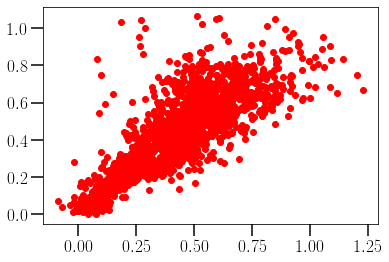

In [91]:
fig, ax = plt.subplots()
ax.scatter(corr_y_pred_mean, y_test[sel])
#ax.set_ylim(0,1)
#ax.set_xlim(0,1)

### Also, consider plotting some pdfs

In [15]:
from scipy import stats
# This pdf gives the probability of a redshift for a given galaxy: the pdf p(z|colors) for each individual galaxy
def gaussian_pdf(zgrid, mean, std):
    pdf = stats.norm.pdf(zgrid, mean, std) # interesting, I don't think I've ever made a pdf this way (I've always done a normalized continuous histogram, I guess)
    return pdf

# Does the xzero correction need to happen here? Or is it ok for it to happen in the gaussians themselves?

def mdn_pdf(zgrid, y_pred_3weights, y_pred_3means, y_pred_3stds): # what do we mean "weights"?
    mix_pdf = np.zeros_like(zgrid)
    for icomp in range(y_pred_3weights.shape[0]): # making a gaussian mixture model!
        mix_pdf += gaussian_pdf(zgrid, y_pred_3means[icomp], y_pred_3stds[icomp]) * y_pred_3weights[icomp]
    sum_pz = np.sum(mix_pdf)#[:,None]
    mix_pdf/=sum_pz
    return mix_pdf

In [16]:
def predict_for_pdfs_old(X_test, model_train, label_test, xzero, sel_ind = 0, galID = 22):
    sel = (label_test == sel_ind)
    Xt = X_test[sel].copy()
    #Xt = preproc.transform(Xt[galID][None, :]) # I guess transform is a function of preproc, which already exists?
    #y_pred = np.array(model_train(Xt)) # is this fundamentally different from predict_zp? yes, because x_correction
    y_pred_means, y_pred_std, y_pred = help_funcs.prediction_zp(Xt, xzero, model_train, preproc, preproc_y, galID)
    # perturb some things
    y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])[0] # go backwards! derive the means of the predicted y's
    y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))[0] # derive the stddevs of the predicted y's
    y_pred_3weights = y_pred[2, :, :][0]
    return y_pred_3means, y_pred_3std, y_pred_3weights

# This way is not a 3-component Gaussian -- it is just picking the mean of the largest component, rather than giving us all of them
def prediction_zp2(xdata, xzero, model_train, preproc, preproc_y, galID = None):
    f_real = xdata.copy()
    f_real[:,:4] = f_real[:,:4] + xzero # So fifth band (magnitude) doesn't get changed, but it should still be there...
    if galID is None:
        f_real = preproc.transform(f_real)
    else:
        f_real = preproc.transform(f_real[galID][None, :])
    y_pred = np.array(model_train(f_real))
    y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1) # This line does not exist in the new version
    y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
    print(y_pred[0, :, :])
    print(y_pred_mean)
    #new_version = preproc_y.inverse_transform(y_pred[0, :, :])[0]
    y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))
    photoz = preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0] # this is the part I don't get... is this finding photo_z's that would lead to the same predictions?
    print("new", photoz)
    photoz_err = preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0]
    return photoz, photoz_err, y_pred # mean, stddev

def predict_for_pdfs2(X_test, model_train, label_test, xzero, sel_ind = 0, galID = 22):
    sel = (label_test == sel_ind)
    Xt = X_test[sel].copy()
    y_pred_means, y_pred_std, y_pred = prediction_zp2(Xt, xzero, model_train, preproc, preproc_y, galID)
    y_pred_weights = y_pred[2, :, :][0]
    return y_pred_means, y_pred_std, y_pred_weights

In [17]:
def predict_for_pdfs(X_test, model_train, label_test, xzero, sel_ind = 0, galID = 22):
    sel = (label_test == sel_ind)
    Xt = X_test[sel].copy()
    Xt[:,:4] = Xt[:,:4] + xzero 
    Xt = preproc.transform(Xt[galID][None, :]) # I guess transform is a function of preproc, which already exists?
    y_pred = np.array(model_train(Xt)) # is this fundamentally different from predict_zp? yes, because x_correction
    y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])[0] # go backwards! derive the means of the predicted y's
    print(y_pred_3means)
    y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))[0] # derive the stddevs of the predicted y's
    y_pred_3weights = y_pred[2, :, :][0]
    return y_pred_3means, y_pred_3std, y_pred_3weights

[ 0.101 -0.001  0.341]
[ 0.096 -0.067  0.333]


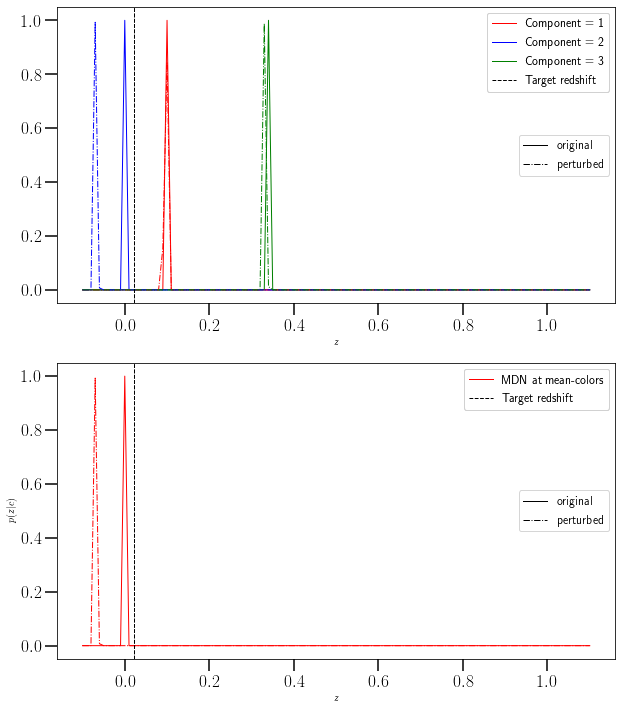

In [18]:
# og and perturbed y preds
sel_ind = 0
sel = (label_test == sel_ind)
galID = 22
f, ax = plt.subplots(2,1, figsize = (10, 12))

xzero_correction = np.loadtxt(save_mod + '_xzero_' + surveystring[sel_ind])
og_y_pred_3means, og_y_pred_3std, og_y_pred_3weights = predict_for_pdfs(X_test, model_train, label_test, xzero_correction, sel_ind = 0, galID = 22)
prtb_X_test = help_funcs.perturb(copy.deepcopy(X_test), approach = 'd', X_err = copy.deepcopy(X_err))
prtb_y_pred_3means, prtb_y_pred_3std, prtb_y_pred_3weights = predict_for_pdfs(prtb_X_test, model_train, label_test, xzero_correction, sel_ind = 0, galID = 22)

colors = ['r', 'b', 'g']
linestyles = iter(['-', '-.'])
ls_labels = iter(["original", "perturbed"])
top_dummy_lines = []
bottom_dummy_lines = []
for i, (y_pred_3means, y_pred_3std, y_pred_3weights) in enumerate(zip([og_y_pred_3means, prtb_y_pred_3means], [og_y_pred_3std, prtb_y_pred_3std], [og_y_pred_3weights, prtb_y_pred_3weights])):
    
    # Create mixed gaussian
    zgrid = np.arange(-0.1,1.1,0.01)
    gm1 = gaussian_pdf(zgrid, y_pred_3means[0], y_pred_3std[0]) # find the gaussian pdf for each color (or is this for each survey?)
    gm1/=np.sum(gm1)
    gm2 = gaussian_pdf(zgrid, y_pred_3means[1], y_pred_3std[1])
    gm2/=np.sum(gm2)
    gm3 = gaussian_pdf(zgrid, y_pred_3means[2], y_pred_3std[2])
    gm3/=np.sum(gm3)
    pdf = mdn_pdf(zgrid, y_pred_3weights, y_pred_3means, y_pred_3std) # hmm so we add up gaussians to get the mdn_pdf?

    # Do the actual plotting (top panel)
    this_linestyle = next(linestyles)
    this_label = next(ls_labels)
    ax[0].plot(zgrid, gm1, linestyle = this_linestyle, color = colors[0], label = 'Component =1')
    ax[0].plot(zgrid, gm2, linestyle = this_linestyle, color = colors[1], label = 'Component =2')
    ax[0].plot(zgrid, gm3, linestyle = this_linestyle, color = colors[2], label = 'Component =3')
    ax[0].axvline( y_test[sel][galID], color='k', linestyle = '--', label='Target redshift')

    # Double legend for top panel
    if i is 0:
        top_lines = ax[0].get_lines()
    top_legend1 = ax[0].legend([line for line in top_lines], ["Component = 1", "Component = 2", "Component = 3", "Target redshift"], loc=1)
    top_dummy, = ax[0].plot([],[], c="black", ls = this_linestyle)
    top_dummy_lines.append(top_dummy)
    top_legend2 = ax[0].legend(top_dummy_lines, ["original", "perturbed"], loc="center right")
    ax[0].add_artist(top_legend1)

    # Plot bottom panel
    ax[1].plot(zgrid, pdf, label = 'MDN at mean-colors', color = colors[0], linestyle = this_linestyle) 
    ax[1].axvline( y_test[sel][galID], color='k', linestyle = 'dashed', label='Target redshift')
    
    # Double legend for bottom panel
    if i is 0:
        bottom_lines = ax[1].get_lines()
    bottom_legend1 = ax[1].legend([line for line in bottom_lines], ["MDN at mean-colors", "Target redshift"], loc=1)
    bottom_dummy, = ax[1].plot([],[], c="black", ls = this_linestyle)
    bottom_dummy_lines.append(bottom_dummy)
    bottom_legend2 = ax[1].legend(bottom_dummy_lines, ["original", "perturbed"], loc="center right")
    ax[1].add_artist(bottom_legend1)
    
    ax[0].set_xlabel(r'$z$')
    ax[1].set_xlabel(r'$z$')
    ax[1].set_ylabel(r'$p(z|c)$')
    ax[1].set_ylabel(r'$p(z|c)$')

plt.savefig("pdf_perturb.png")
plt.show()

Things to add
- make sure it's zero-pt corrected
- fewer bins
- error bars
    - do these come from `X_err` or are they Poissonian?
- somehow do multiple perturbations (and seeds?) and sort of average them together?
- interpolate with a spline

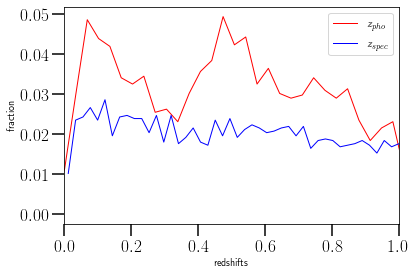

In [39]:
# Maybe I'll just do it myself real quick...
# Your pdf shows for a given redshift, how many galaxies do we expect: it's an aggregate p(z) for all galaxies in the sample
fig, ax = plt.subplots()
y_pred_mean, y_pred_std  = help_funcs.prediction_zp_all(X_test, label_test, save_mod, surveystring, model_train, preproc, preproc_y)

z_pho = y_pred_mean
z_spec = y_test # not even a real z_spec *rolls eyes*

nbins = 50
labels = [r"$z_{pho}$", r"$z_{spec}$"]
for i, z in enumerate([z_pho, z_spec]):
    hist = np.histogram(z, nbins)
    norm_factor = len(z)
    bin_centers = (hist[1][:-1] + hist[1][1:]) / 2
    plt.plot(bin_centers, hist[0]/norm_factor, linestyle = '-', label = labels[i])
    
plt.legend()
plt.xlim(0,1)
plt.xlabel("redshifts")
plt.ylabel("fraction")
plt.savefig("pdf_zs.png")

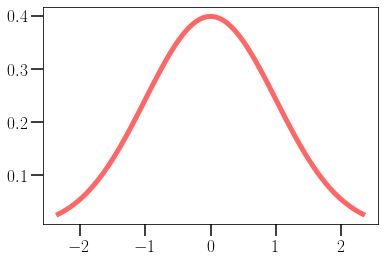

In [38]:
from scipy.stats import norm
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100) # 1% to 99% probability (?)
#print(x)
#print(norm.pdf(x))
plt.plot(x, norm.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')

### Other stuff

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using

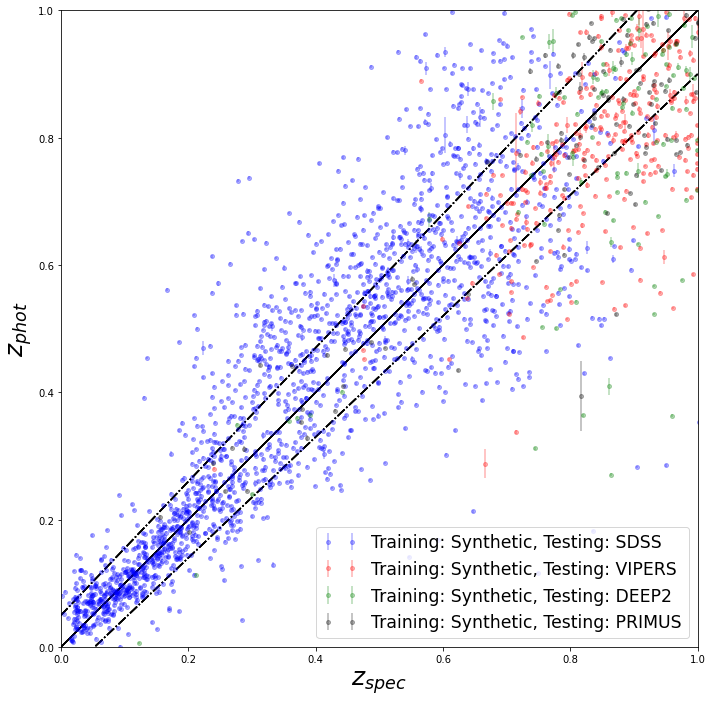

In [51]:
## Plotting survey-based predictions. With a manually set offset 
offset = 0.04


for label_ind in [0, 1, 2, 3]:
    plt.figure(22,figsize=(10, 10,)) 
    colorstring = ['b', 'r', 'g', 'k']
    surveyindx = np.where(label_test == label_ind) # same idea as sel and sel_ind
    
    plt.errorbar(y_test[surveyindx], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0],
                 yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0],
                 fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind],
                 c = colorstring[label_ind])

    C = 0.05
    z_t = np.array([0, 1])
    z_tp = z_t + C*(1+z_t)
    z_tm = z_t - C*(1+z_t)
    plt.plot(z_t, z_t, 'k')
    plt.plot(z_t, z_tp, 'k-.')
    plt.plot(z_t, z_tm, 'k-.')

    plt.ylabel(r'$z_{phot}$', fontsize=25)
    plt.xlabel(r'$z_{spec}$', fontsize=25)
    plt.xlim(0.0, 1)
    plt.ylim(0.0, 1)
    plt.tight_layout()
    plt.axes().set_aspect('equal')
    leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

## Old-ish stuff

In [ ]:
## Prediction 
X_test = preproc.transform(X_test)
y_pred = np.array(model_train(X_test))

In [ ]:
## Best prediction (mean and std) of the Gaussian mixture is taken as the the one with highest weight
y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0])

In [ ]:
## Plotting mean and std-dev of predictions. The bias in prediction is clearly seen (esp at low-z)
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std

plt.figure(figsize=(10, 10))

plt.errorbar(y_test, preproc_y.inverse_transform(y_pred_mean.reshape(-1, 1))[:, 0], 
             yerr= preproc_y.inverse_transform(y_pred_std.reshape(-1, 1) )[:, 0], 
             fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')

C = 0.05
z_t = np.array([0, 1])
z_tp = z_t + C*(1+z_t)
z_tm = z_t - C*(1+z_t)
plt.plot(z_t, z_t, 'k')
plt.plot(z_t, z_tp, 'k-.')
plt.plot(z_t, z_tm, 'k-.')
plt.ylabel(r'$z_{phot}$', fontsize=25)
plt.xlabel(r'$z_{spec}$', fontsize=25)
plt.tight_layout()
plt.axes().set_aspect('equal')
leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

plt.show()

In [ ]:
# Old way to perturb and plot
# Perturb one band (or multiple)
band_n = 4
delta_c = 0.95
approach = 'd'
prtb_X_test = help_funcs.perturb(X_test, band_n, delta_c = delta_c, approach = approach, X_err = X_err)
#print(prtb_X_test.shape)
#print(prtb_X_test)

# Compare perturbed and unperturbed predictions (mean and std-dev)
og_y_pred_mean, og_y_pred_std = help_funcs.predict(X_test, preproc, model_train)
prtb_y_pred_mean, prtb_y_pred_std = help_funcs.predict(prtb_X_test, preproc, model_train)

# Plot those comparisons
if approach != 'd':
    labels = ["original", "perturbed: " + str(band_n)]
else:
    labels = ["original", "perturbed"]
fig, axs = help_funcs.plot_side_by_sides(y_test, preproc_y, [og_y_pred_mean, prtb_y_pred_mean], [og_y_pred_std, prtb_y_pred_std], labels, approach, band_n, delta_c)

# Title and save
save = False
if save:
    if approach != 'd':
        suffix = "_deltac_" + str(delta_c) if approach == 'a' else ""
        fig.savefig(approach + "_compare_band_" + str(band_n) + suffix + ".png")
    else:
        fig.savefig("d_compare_all_bands" + ".png")
fig.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2551 but corresponding boolean dimension is 1922

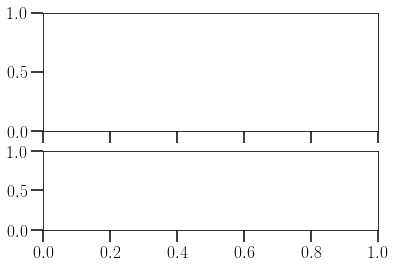

In [36]:
# Special version for approach d (???)
# Perturb lots of bands
approach = 'd' # b, c, or d # Not sure if d actually makes that much sense?
metric_name = r'$\sigma_{NMAD}$'
sel_ind = 0 # pick a survey
sel = (label_test == sel_ind) # masks the selection index
xzero_correction = np.loadtxt(save_mod + '_xzero_' + surveystring[sel_ind])
ncol = 3 # Should this actually be vertical and outside the plots, perhaps?

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, gridspec_kw={'height_ratios': [3, 2]})

# Perturb the data
prtb_X_test = help_funcs.perturb(X_test, band_n, delta_c, approach, X_err = X_err)
prtb_y_pred_mean, prtb_y_pred_std  = help_funcs.prediction_zp(prtb_X_test[sel], xzero_correction, model_train, preproc, preproc_y)
og_y_pred_mean, og_y_pred_std  = help_funcs.prediction_zp(X_test[sel], xzero_correction, model_train, preproc, preproc_y)

# Validate and plot og data first
og_sigmaNMAD_array, og_outFr_array, bins = help_funcs.validate(y_test, sel, y_pred_mean)
if metric_name == r'$\sigma_{NMAD}$':
    og_metric = og_sigmaNMAD_array
elif metric_name == "outFrac":
    og_metric = og_outFr_array
fig, ax1 = help_funcs.plot_metric(og_metric, metric_name, approach, fig = fig, ax = ax1, label = "original", color = "black", linestyle = '-')
ax1.legend(ncol = ncol)

# Now plot the validations of the perturbed data
print(len(prtb_y_pred_mean_lst))
sigmaNMAD_array, outFr_array, bins = help_funcs.validate(y_test, sel, prtb_y_pred_mean) # How are you getting a different thing everytime when it's approach 'd'?
if metric_name == "sigma":
    metric = sigmaNMAD_array
elif metric_name == "outFrac":
    metric = outFr_array
fig, ax1 = help_funcs.plot_metric(metric, metric_name, approach, fig = fig, ax = ax1, label = "perturbed", linestyle = '--')
ax1.legend(ncol = ncol)

# Look at relative difference
relative_diff = (metric[:-1] - og_metric[:-1]) / og_metric[:-1] # remove last value, which is always 0
ax2.plot(bins[:-1], relative_diff, linestyle = ":")
ax2.set_ylabel("Rel diff")
ax2.set_xlabel("z bins")
    
fig.savefig(metric_name + "_approach_" + approach + "_rel" + ".png")